In [93]:
from astropy.time import Time
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
plt.style.use('default')
from scipy.signal import find_peaks, peak_prominences
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import GPy
from sklearn.metrics import mean_squared_error

np.random.seed(42)
#

In [245]:
data_path = '../../Data/'
work_path = '.'
save_path = '../../../Presentations/AstroAI_Workshop_2024/Presentation/'

# Raw Data

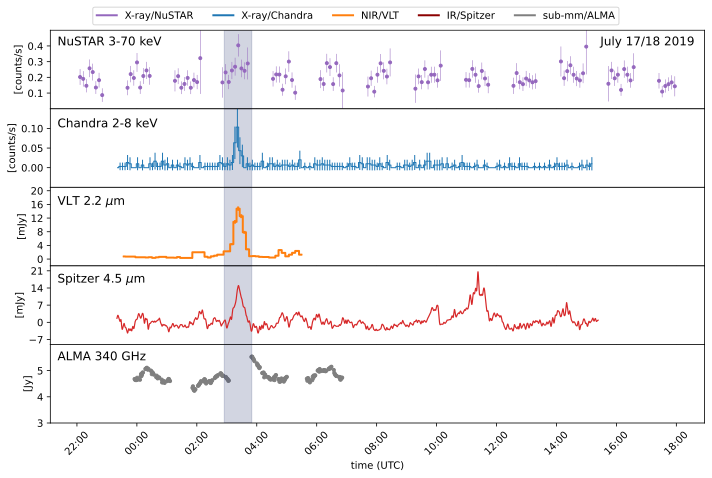

In [246]:
# Create a single figure with three subplots that share the same x-axis
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)

# Plot 1
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
flux1 = df1[:, 1]
error1 = df1[:, 2]
time1 = (Time(bmjd1, format='mjd', scale='tcb').utc).to_datetime()
axs[0].errorbar(time1, flux1, error1, fmt='o', color='tab:purple', markersize=3, linewidth=0.5)
axs[0].set_ylim(0, 0.5)
axs[0].set_yticks([0.1, 0.2, 0.3, 0.4])
axs[0].set_ylabel('[counts/s]')

# Plot 2
file2 = data_path + '0718chan.dat'
df2 = np.genfromtxt(file2, delimiter=' ')
bmjd2 = df2[:, 0]
flux2 = df2[:, 1]
error2 = df2[:, 2]
time2 = (Time(bmjd2, format='mjd', scale='tcb').utc).to_datetime()
axs[1].errorbar(time2, flux2, error2, linewidth=1, drawstyle='steps-mid', color='tab:blue')
axs[1].set_ylim(-0.05, 0.15)
axs[1].set_yticks([0.0, 0.05, 0.10])
axs[1].set_ylabel('[counts/s]')

# Plot 3
file3 = data_path + '0718grav.dat'
df3 = np.genfromtxt(file3)
bmjd3 = df3[:, 0]
flux3 = df3[:, 1]
error3 = df3[:, 2]
time3 = (Time(bmjd3, format='mjd', scale='tcb').utc).to_datetime()
axs[2].errorbar(time3, flux3, error3, linewidth=2, drawstyle='steps-mid', color='tab:orange')
axs[2].set_ylim(-2, 21)
axs[2].set_yticks([0, 4, 8, 12, 16, 20])
axs[2].set_ylabel('[mJy]')

# Plot 4
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
time4 = (Time(bmjd4, format='mjd', scale='tcb').utc).to_datetime()
axs[3].plot(time4, flux_binned4, linewidth=1.2, color='tab:red')
# axs[3].scatter(time4, flux_excess4, color='red', alpha=0.05, s=2)
axs[3].set_ylim(-9, 23)
axs[3].set_yticks([-7, 0, 7, 14, 21])
axs[3].set_ylabel('[mJy]')

# Plot 5
file5 = data_path + '0718alma.dat'
df5 = np.genfromtxt(file5, delimiter=' ')
bmjd5 = df5[:, 2]
flux5 = df5[:, 3]
time5 = (Time(bmjd5, format='mjd', scale='tcb').utc).to_datetime()
axs[4].scatter(time5, flux5, s=10, color='tab:gray')
axs[4].set_ylim(3, 6)
axs[4].set_yticks([3.0, 4.0, 5.0])
axs[4].set_ylabel('[Jy]')

# Adjust subplot spacing
plt.tight_layout()

for ax in axs:
    ax.label_outer()

# Customize the x-axis tick labels
start_time = datetime.strptime('2019-07-17 22:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
end_time = datetime.strptime('2019-07-18 18:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
interval = timedelta(hours=2)
xticks = [start_time + i * interval for i in range(int((end_time - start_time) / interval) + 1)]
xtick_labels = [t.strftime('%H:%M') for t in xticks]

# Set the x-axis tick positions and labels for all subplots
axs[4].set_xticks(xticks)
axs[4].set_xticklabels(xtick_labels, rotation=45)
axs[4].set_xlabel('time (UTC)')

# Manually set x-axis limits to start at "00:00"
xstart = datetime.strptime('2019-07-17 23:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
xend = datetime.strptime('2019-07-18 15:30:00.0', "%Y-%m-%d %H:%M:%S.%f")

legend_handles = [Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
                 Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
                 Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
                 Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
                 Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),]

# Add date
fig.text(0.84, 0.94, 'July 17/18 2019', fontsize=12)
fig.text(0.085, 0.94, 'NuSTAR 3-70 keV', fontsize=12)
fig.text(0.085, 0.75, 'Chandra 2-8 keV', fontsize=12)
fig.text(0.085, 0.57, fr'VLT 2.2 $\mu$m', fontsize=12)
fig.text(0.085, 0.39, 'Spitzer 4.5 $\mu$m', fontsize=12)
fig.text(0.085, 0.21, 'ALMA 340 GHz', fontsize=12)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

for ax in axs:
    ax.axvspan('2019-07-18 02:55:00.0', '2019-07-18 03:50:00.0', color='#222e69', alpha=0.2)

# Show the combined figure
plt.savefig(save_path + 'raw_data.png', bbox_inches='tight')
plt.show()

# GP Example 1

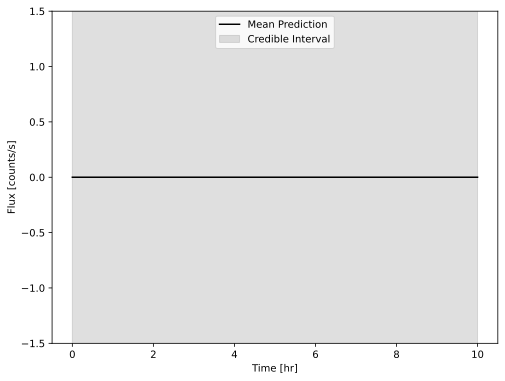

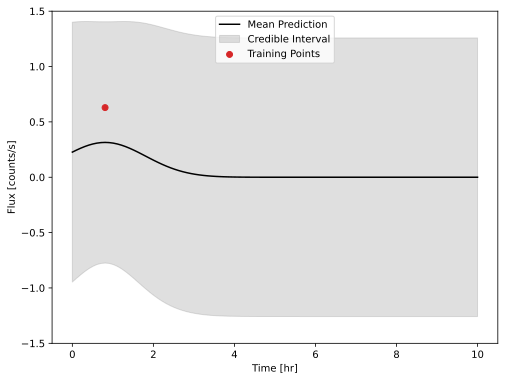

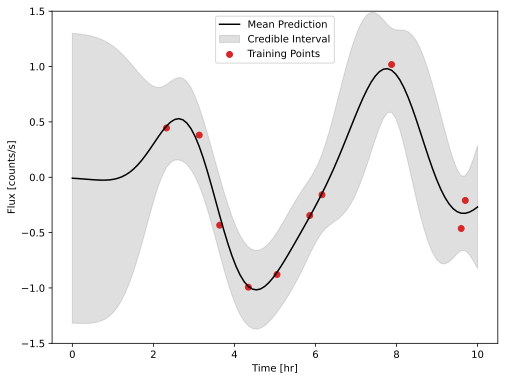

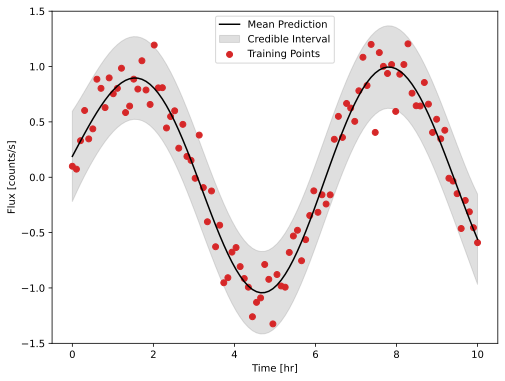

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Create a mock spectrum
np.random.seed(42)
X = np.linspace(0, 10, 100)[:, None]
Y = np.sin(X) + 0.2 * np.random.randn(100, 1)

# Define a GP model with an RBF kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
model = GPy.models.GPRegression(X, Y, kernel)

# Create a list of the number of training points to use for each plot
num_points_list = [0, 1, 10, 100]

# Generate and save the plots
for i, num_points in enumerate(num_points_list):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    
    match num_points:
        case 0:
            X_train = np.array([[-5]])
            Y_train = np.array([[0]])
            model.set_XY(X_train, Y_train)
        case 1:
            indices = np.random.randint(0, 100, 1)
            X_train = X[indices]
            Y_train = Y[indices]
            model.set_XY(X_train, Y_train)
            model.optimize()
        case 10:
            indices = np.random.randint(0, 100, 10)
            X_train = X[indices]
            Y_train = Y[indices]
            model.set_XY(X_train, Y_train)
            model.optimize()  
        case 100:
            X_train = X[:num_points]
            Y_train = Y[:num_points]
            model.set_XY(X_train, Y_train)
            model.optimize()                              
    # if num_points > 0:
    #     X_train = X[:num_points]
    #     Y_train = Y[:num_points]
    # else:
    #     X_train = np.array([[-5]])
    #     Y_train = np.array([[0]])
    #     model.set_XY(X_train, Y_train)
    
    # if num_points > 0:
    #     model.set_XY(X_train, Y_train)
    #     model.optimize()
    
    # Predict the mean and variance for the entire input range
    mu, variance = model.predict(X)
    
    # Plot the mean and confidence interval
    plt.plot(X, mu, 'black', label='Mean Prediction')
    plt.fill_between(X.flatten(), 
                     mu.flatten() - 2 * np.sqrt(variance.flatten()), 
                     mu.flatten() + 2 * np.sqrt(variance.flatten()), 
                     color='grey', alpha=0.25, label='Credible Interval')
    
    # Plot the training points
    if num_points > 0:
        plt.scatter(X_train, Y_train, label='Training Points', color='tab:red', marker='o')
    
    plt.ylim(-1.5, 1.5)
    plt.xlabel('Time [hr]')
    plt.ylabel('Flux [counts/s]')
    plt.legend(loc='upper center')
    
    # Save the plot with a unique filename
    plt.savefig(save_path + f'GP_fit_{num_points}_training_points.png')
    plt.show()  # Display the plot (optional, can be removed if only saving)


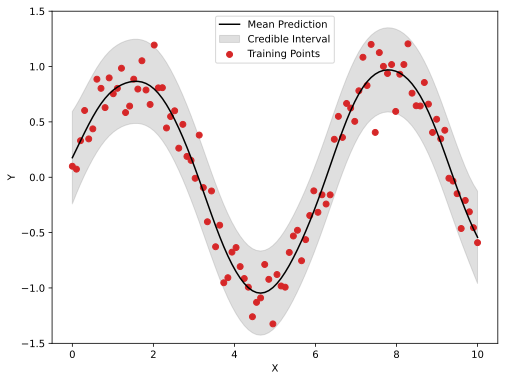

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Create a mock spectrum
np.random.seed(42)
X = np.linspace(0, 10, 100)[:, None]
Y = np.sin(X) + 0.2 * np.random.randn(100, 1)

# Define a GP model with an RBF kernel
kernel = GPy.kern.Matern52(1)
model = GPy.models.GPRegression(X, Y, kernel)

# Create a list of the number of training points to use for each plot
num_points_list = [100]

# Generate and save the plots
for i, num_points in enumerate(num_points_list):
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    
    if num_points > 0:
        X_train = X[:num_points]
        Y_train = Y[:num_points]
    else:
        X_train = np.array([[-5]])
        Y_train = np.array([[0]])
        model.set_XY(X_train, Y_train)
    
    if num_points > 0:
        model.set_XY(X_train, Y_train)
        model.optimize()
    
    # Predict the mean and variance for the entire input range
    mu, variance = model.predict(X)
    
    # Plot the mean and confidence interval
    plt.plot(X, mu, 'black', label='Mean Prediction')
    plt.fill_between(X.flatten(), 
                     mu.flatten() - 2 * np.sqrt(variance.flatten()), 
                     mu.flatten() + 2 * np.sqrt(variance.flatten()), 
                     color='grey', alpha=0.25, label='Credible Interval')
    
    # Plot the training points
    if num_points > 0:
        plt.scatter(X_train, Y_train, label='Training Points', color='tab:red', marker='o')
    
    plt.ylim(-1.5, 1.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper center')
    
    # Save the plot with a unique filename
    if num_points == 100:
        plt.savefig(save_path + 'SOGP_matern')
    plt.show()  # Display the plot (optional, can be removed if only saving)


# MOGP Example

## One Peak

In [98]:
def sinc(x, width=1, alpha=0.5):
    return np.sinc(x / width) #* np.exp(-alpha * x**2)

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Create a mock spectrum
np.random.seed(42)
X1 = np.linspace(0, 10, 100)[:, None]
Y1 = np.sin(X + np.pi) + 0.2 * np.random.randn(100, 1)

X2 = np.linspace(0, 10, 100)[:, None]
# Y2 = -np.exp(-0.5 * ((X2 - 5) ** 2) / 1)
Y2 = sinc(X2 - 5) + 0.025 * np.random.randn(100, 1)

X3 = np.linspace(0, 10, 100)[:, None]
Y3 = np.exp(-0.5 * ((X2 - 5) ** 2) / 1) + 0.025 * np.random.randn(100, 1)

# Normalize Y1
Y1_mean = Y1.mean()
Y1_std = Y1.std()
Y1 = (Y1 - Y1_mean) / Y1_std

# Normalize Y2
Y2_mean = Y2.mean()
Y2_std = Y2.std()
Y2 = (Y2 - Y2_mean) / Y2_std

# Normalize Y3
Y3_mean = Y3.mean()
Y3_std = Y3.std()
Y3 = (Y3 - Y3_mean) / Y3_std

lower = 1.5
upper = 8.5

# Condition the model only on points between x=0 and x=lower and x=upper and x=10
X_train = X1[(X1 < lower) | (X1 > upper)].reshape(-1, 1)
Y_train = Y1[(X1 < lower) | (X1 > upper)].reshape(-1, 1)
X_test = X1[(X1 >= lower) & (X1 <= upper)].reshape(-1, 1)
Y_test = Y1[(X1 >= lower) & (X1 <= upper)].reshape(-1, 1)

# Define a GP model with an RBF kernel
K1 = GPy.kern.Bias(1) # Bias kernel K_bias. Controls the mean function of the GP
K2 = GPy.kern.Matern52(1) # RBF kernel K_rbf
K3 = GPy.kern.White(1)

lcm = GPy.util.multioutput.LCM(input_dim = 1, num_outputs = 3, kernels_list = [K1, K2]) # LCM kernel. Adds coregionalization matrix to each kernel in the list: B_1 x K_bias + B_2 x K_rbf

model = GPy.models.GPCoregionalizedRegression(X_list = [X_train, X2, X3], Y_list = [Y_train, Y2, Y3], kernel = lcm) # X2 = Chandra, X3 = VLT, X_train = Spitzer
# model['sum.ICM0.B.W'].constrain_fixed(0)
# model['sum.ICM0.B.kappa'].constrain_fixed(0)
# model['sum.ICM1.Mat32.lengthscale'].constrain_bounded(0, 0.5)

# optimize model
model.optimize()

display(model)
print(model.param_array)

[ 1.00427044e-147  3.04592366e+001  7.02561712e+000 -2.79046790e+001
  3.39786722e-039  6.06126285e-018  9.94702206e-090  3.73209053e-002
  1.86558767e+000  9.80338026e-001  1.35616483e+001  2.32137554e+000
  4.94447526e+001  4.22131441e+001  1.52605909e+001  4.17029315e-002
  6.65726790e-003  6.49740881e-003]


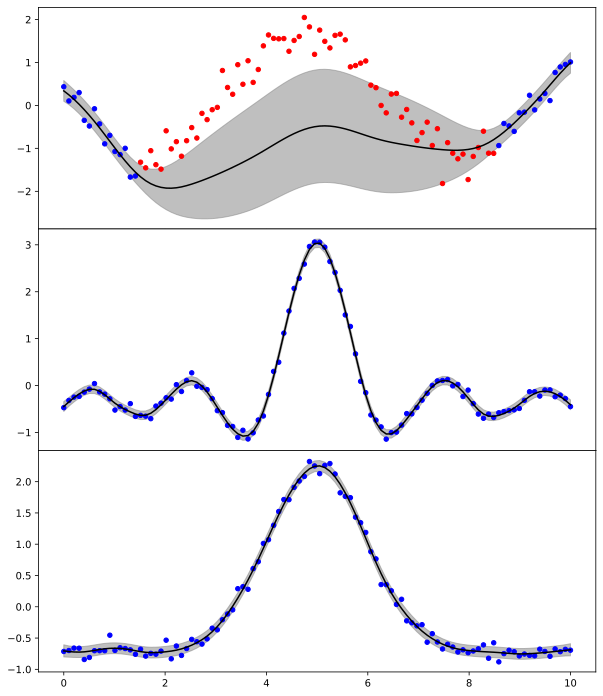

In [100]:
X_test_with_index1 = np.hstack((X1, (0 * np.ones_like(X1)).reshape(-1,1)))
Y_metadata1 = {'output_index': X_test_with_index1[:, 1:].astype(int)}
preds1 = model.predict(X_test_with_index1, Y_metadata=Y_metadata1)
lower1, upper1 = model.predict_quantiles(X=X_test_with_index1, Y_metadata=Y_metadata1, quantiles=(16, 84))
lower1, upper1 = lower1.flatten(), upper1.flatten()

X_test_with_index2 = np.hstack((X2, (1 * np.ones_like(X2)).reshape(-1,1)))
Y_metadata2 = {'output_index': X_test_with_index2[:, 1:].astype(int)}
preds2 = model.predict(X_test_with_index2, Y_metadata=Y_metadata2)
lower2, upper2 = model.predict_quantiles(X=X_test_with_index2, Y_metadata=Y_metadata2, quantiles=(16, 84))
lower2, upper2 = lower2.flatten(), upper2.flatten()

X_test_with_index3 = np.hstack((X3, (2 * np.ones_like(X3)).reshape(-1,1)))
Y_metadata3 = {'output_index': X_test_with_index3[:, 1:].astype(int)}
preds3 = model.predict(X_test_with_index3, Y_metadata=Y_metadata3)
lower3, upper3 = model.predict_quantiles(X=X_test_with_index3, Y_metadata=Y_metadata3, quantiles=(16, 84))
lower3, upper3 = lower3.flatten(), upper3.flatten()

fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)

axs[0].fill_between(X1.flatten(), lower1, upper1, alpha=0.5, color='grey')
axs[0].scatter(X_train, Y_train, s=20, color='b')
axs[0].plot(X1, preds1[0].flatten(), color='black')
axs[0].scatter(X_test, Y_test, s=20, color='r')


axs[1].fill_between(X2.flatten(), lower2, upper2, alpha=0.5, color='grey')
axs[1].scatter(X2, Y2, s=20, color='b')
axs[1].plot(X2, preds2[0].flatten(), color='black')

axs[2].fill_between(X3.flatten(), lower3, upper3, alpha=0.5, color='grey')
axs[2].scatter(X3, Y3, s=20, color='b')
axs[2].plot(X3, preds3[0].flatten(), color='black')

plt.show()

## Two Peaks

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Generate mock datasets
np.random.seed(42)

# Dataset 1: Sine function with two peaks
X1 = np.linspace(0, 10, 100)[:, None]
period = 4.0  # Adjust the period to control the distance between peaks
omega = 2 * np.pi / period
Y1 = np.sin(omega * X1 + np.pi) + 0.2 * np.random.randn(100, 1)


# Dataset 2: Double sinc function
X2 = np.linspace(0, 10, 100)[:, None]
Y2 = sinc(X2 - 3) + sinc(X2 - 7) + 0.1 * np.random.randn(100, 1)

# Dataset 3: Gaussian function with two peaks
X3 = np.linspace(0, 10, 100)[:, None]
Y3 = np.exp(-0.5 * ((X3 - 3) ** 2) / 0.5) + np.exp(-0.5 * ((X3 - 7) ** 2) / 0.5) + 0.1 * np.random.randn(100, 1)

Y2 = np.sin(omega * X1 + np.pi) + 0.2 * np.random.randn(100, 1)

# Normalize datasets
def normalize(Y):
    Y_mean = Y.mean()
    Y_std = Y.std()
    return (Y - Y_mean) / Y_std

Y1 = normalize(Y1)
Y2 = normalize(Y2)
Y3 = normalize(Y3)

# Withhold the first peak of Dataset 1 for testing
lower = 0
upper = 6

X_train = X1[(X1 < lower) | (X1 > upper)].reshape(-1, 1)
Y_train = Y1[(X1 < lower) | (X1 > upper)].reshape(-1, 1)
X_test = X1[(X1 >= lower) & (X1 <= upper)].reshape(-1, 1)
Y_test = Y1[(X1 >= lower) & (X1 <= upper)].reshape(-1, 1)

# Define kernels
K1 = GPy.kern.Bias(1)  # Bias kernel
K2 = GPy.kern.RBF(1)   # RBF kernel
K3 = GPy.kern.White(1)   # RBF kernel
K4 = GPy.kern.Matern52(1)

X_list = [X_train, X2]
Y_list = [Y_train, Y2]
K_list = [K2]
num_outputs = len(X_list)

# LCM kernel with three outputs
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=num_outputs, kernels_list=K_list)

# Create the GP coregionalized regression model
model = GPy.models.GPCoregionalizedRegression(X_list=X_list, Y_list=Y_list, kernel=lcm)

# Constraints
# model['ICM0.B.kappa'].constrain_fixed(0)
# model['ICM0.B.W'][1].constrain_fixed(0)

# Optimize the model
model.optimize()

# Display model parameters
display(model)
print(model.param_array)


[ 8.98763779e-03  1.28777600e+00 -1.70454552e+01 -1.71756814e+01
  9.15026461e-07  6.95730541e-08  6.45653999e-02  5.91746205e-02]


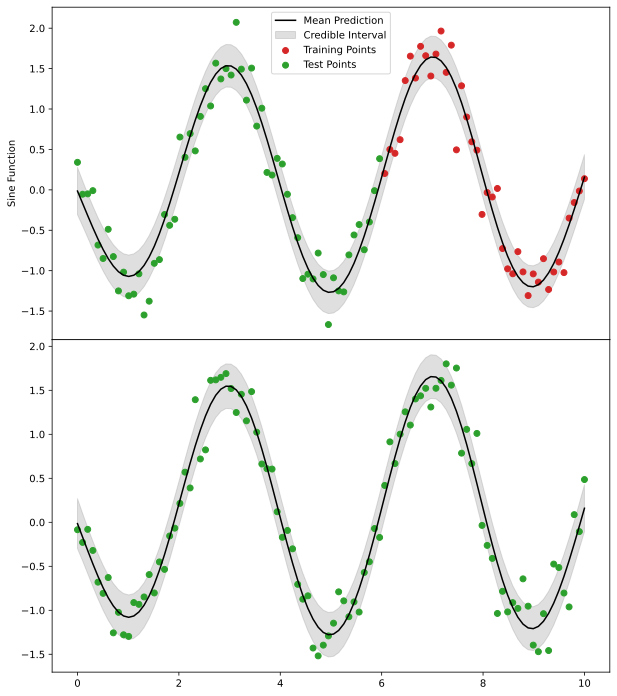

In [102]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(num_outputs, hspace=0)
axs = gs.subplots(sharex=True)

for i, X, Y in zip(range(num_outputs), X_list, Y_list):
    X_test_with_index = np.hstack((X1, (i * np.ones_like(X1)).reshape(-1,1)))
    Y_metadata = {'output_index': X_test_with_index[:, 1:].astype(int)}
    preds = model.predict(X_test_with_index, Y_metadata=Y_metadata)
    lower, upper = model.predict_quantiles(X=X_test_with_index, Y_metadata=Y_metadata, quantiles=(16, 84))
    lower, upper = lower.flatten(), upper.flatten()    

    if i == 0:
        axs[i].plot(X1, preds[0].flatten(), color='black', label='Mean Prediction')
        axs[i].fill_between(X1.flatten(), lower, upper, alpha=0.25, color='grey', label='Credible Interval')
        axs[i].scatter(X_train, Y_train, marker='o', color='tab:red', label='Training Points')
        axs[i].scatter(X_test, Y_test, label='Test Points', color='tab:green')
        axs[i].set_ylabel('Sine Function')
        axs[i].legend(loc='upper center')
    else:
        axs[i].plot(X, preds[0].flatten(), color='black')
        axs[i].fill_between(X.flatten(), lower, upper, alpha=0.25, color='grey')
        axs[i].scatter(X, Y, marker='o', color='tab:green')
    # ax.set_ylabel('Sinc Functions')

plt.show()


# # plt.savefig(save_path + 'MOPG2.png')

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Generate mock datasets
np.random.seed(42)

# Dataset 1: Sine function with two peaks
X1 = np.linspace(0, 10, 100)[:, None]
period = 4.0  # Adjust the period to control the distance between peaks
omega = 2 * np.pi / period
Y1 = np.sin(omega * X1 + np.pi) + 0.2 * np.random.randn(100, 1)

# Dataset 2: Double sinc function
X2 = np.linspace(0, 10, 100)[:, None]
Y2 = sinc(X2 - 3) + sinc(X2 - 7) + 0.1 * np.random.randn(100, 1)
# Y2 = sinc(X2 - 7) + 0.025 * np.random.randn(100, 1)

# Dataset 3: Gaussian function with two peaks
X3 = np.linspace(0, 10, 100)[:, None]
Y3 = np.exp(-0.5 * ((X3 - 3) ** 2) / 0.5) + np.exp(-0.5 * ((X3 - 7) ** 2) / 0.5) + 0.1 * np.random.randn(100, 1)
# Y3 = np.exp(-0.5 * ((X3 - 7) ** 2) / 0.5) + 0.5 * np.random.randn(100, 1)

X4 = np.linspace(0, 10, 100)[:, None]
Y4 = sinc(X4 - 3) + sinc(X4 - 7) + 0.1 * np.random.randn(100, 1)

# Normalize datasets
def normalize(Y):
    Y_mean = Y.mean()
    Y_std = Y.std()
    return (Y - Y_mean) / Y_std

Y1 = normalize(Y1)
Y2 = normalize(Y2)
Y3 = normalize(Y3)
Y4 = normalize(Y4)

# Withhold the first peak of Dataset 1 for testing
lower = 0
upper = 6

X_train = X1[(X1 < lower) | (X1 > upper)].reshape(-1, 1)
Y_train = Y1[(X1 < lower) | (X1 > upper)].reshape(-1, 1)
X_test = X1[(X1 >= lower) & (X1 <= upper)].reshape(-1, 1)
Y_test = Y1[(X1 >= lower) & (X1 <= upper)].reshape(-1, 1)

# Define kernels
K1 = GPy.kern.Bias(1)  # Bias kernel
K2 = GPy.kern.RBF(1)   # RBF kernel
K3 = GPy.kern.White(1)   # RBF kernel
K4 = GPy.kern.Matern52(1)

# LCM kernel with three outputs
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=3, kernels_list=[K2])

# Create the GP coregionalized regression model
model = GPy.models.GPCoregionalizedRegression(X_list=[X_train, X2, X3], Y_list=[Y_train, Y2, Y3], kernel=lcm)

# Optimize the model
model.optimize()

# Display model parameters
display(model)
print(model.param_array)


[ 9.94382620e-02  7.47543890e-01 -2.53497791e+00 -2.97435128e+00
 -2.73026594e+00  9.41288370e-01  5.03151638e+00  4.69021398e-06
  7.12616076e-02  6.31867591e-02  9.63882653e-02]


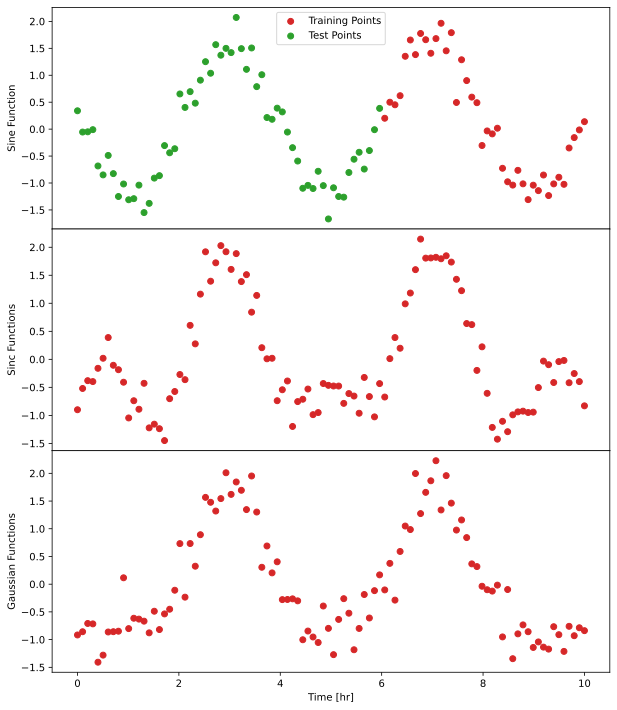

In [104]:
X_test_with_index1 = np.hstack((X1, (0 * np.ones_like(X1)).reshape(-1,1)))
Y_metadata1 = {'output_index': X_test_with_index1[:, 1:].astype(int)}
preds1 = model.predict(X_test_with_index1, Y_metadata=Y_metadata1)
lower1, upper1 = model.predict_quantiles(X=X_test_with_index1, Y_metadata=Y_metadata1, quantiles=(16, 84))
lower1, upper1 = lower1.flatten(), upper1.flatten()

X_test_with_index2 = np.hstack((X2, (1 * np.ones_like(X2)).reshape(-1,1)))
Y_metadata2 = {'output_index': X_test_with_index2[:, 1:].astype(int)}
preds2 = model.predict(X_test_with_index2, Y_metadata=Y_metadata2)
lower2, upper2 = model.predict_quantiles(X=X_test_with_index2, Y_metadata=Y_metadata2, quantiles=(16, 84))
lower2, upper2 = lower2.flatten(), upper2.flatten()

X_test_with_index3 = np.hstack((X3, (2 * np.ones_like(X3)).reshape(-1,1)))
Y_metadata3 = {'output_index': X_test_with_index3[:, 1:].astype(int)}
preds3 = model.predict(X_test_with_index3, Y_metadata=Y_metadata3)
lower3, upper3 = model.predict_quantiles(X=X_test_with_index3, Y_metadata=Y_metadata3, quantiles=(16, 84))
lower3, upper3 = lower3.flatten(), upper3.flatten()

# X_test_with_index4 = np.hstack((X4, (3 * np.ones_like(X4)).reshape(-1,1)))
# Y_metadata4 = {'output_index': X_test_with_index4[:, 1:].astype(int)}
# preds4 = model.predict(X_test_with_index4, Y_metadata=Y_metadata4)
# lower4, upper4 = model.predict_quantiles(X=X_test_with_index4, Y_metadata=Y_metadata4, quantiles=(16, 84))
# lower4, upper4 = lower4.flatten(), upper4.flatten()

fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)

# axs[0].plot(X1, preds1[0].flatten(), color='black', label='Mean Prediction')
# axs[0].fill_between(X1.flatten(), lower1, upper1, alpha=0.25, color='grey', label='Credible Interval')
axs[0].scatter(X_train, Y_train, marker='o', label='Training Points', color='tab:red')
axs[0].scatter(X_test, Y_test, label='Test Points', color='tab:green')
axs[0].set_ylabel('Sine Function')
axs[0].legend(loc='upper center')

# axs[1].plot(X2, preds2[0].flatten(), color='black')
# axs[1].fill_between(X2.flatten(), lower2, upper2, alpha=0.25, color='grey')
axs[1].scatter(X2, Y2, marker='o', color='tab:red')
axs[1].set_ylabel('Sinc Functions')

# axs[2].plot(X3, preds3[0].flatten(), color='black')
# axs[2].fill_between(X3.flatten(), lower3, upper3, alpha=0.25, color='grey')
axs[2].scatter(X3, Y3, marker='o', color='tab:red')
axs[2].set_xlabel('Time [hr]')
axs[2].set_ylabel('Gaussian Functions')

plt.savefig(save_path + 'MOPG1.png')
plt.show()

# GP Example 2

In [105]:
model = GPy.models.GPRegression(X_train, Y_train, kernel=GPy.kern.RBF(1))
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0004   1.659007e+01   3.762240e+01 
    00s03  0015   1.481643e+01   1.479937e-06 
    00s03  0018   1.481643e+01   6.433433e-11 
Runtime:     00s03
Optimization status: Converged



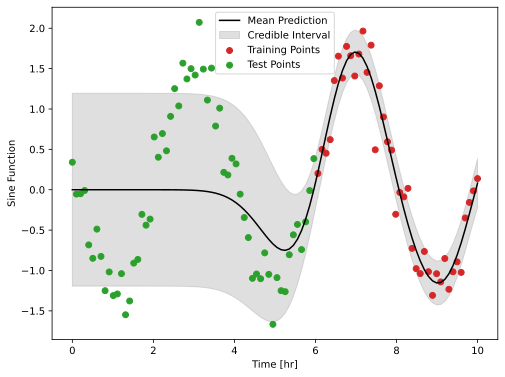

In [106]:
preds = model.predict(X1)
lower, upper = model.predict_quantiles(X=X1, quantiles=(16, 84))
lower, upper = lower.flatten(), upper.flatten()

plt.figure(figsize=(8,6))
plt.plot(X1, preds[0].flatten(), color='black', label='Mean Prediction')
plt.fill_between(X1.flatten(), lower, upper, alpha=0.25, color='grey', label='Credible Interval')
# plt.scatter(np.append(X_train, X_test), np.append(Y_train, Y_test), marker='o', color='tab:red')
plt.scatter(X_train, Y_train, marker='o', color='tab:red', label='Training Points')
plt.scatter(X_test, Y_test, label='Test Points', color='tab:green')
plt.xlabel('Time [hr]')
plt.ylabel('Sine Function')
plt.legend(loc='upper center')

plt.savefig(save_path + 'SOGP3.png')
plt.show()

# MOGP On Real Data

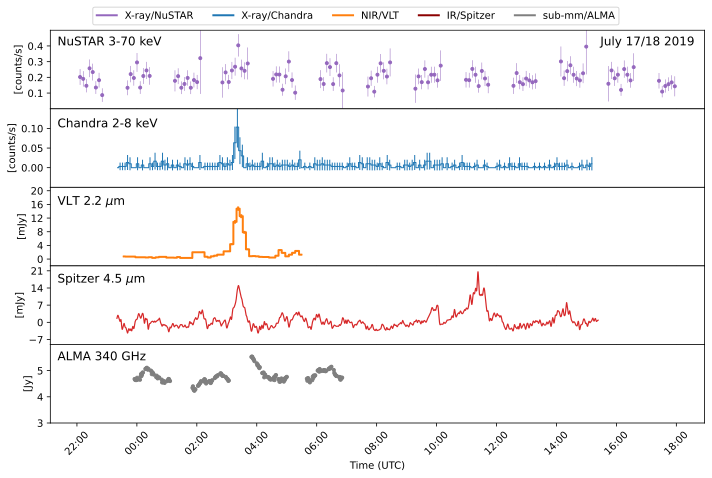

In [242]:
# Create a single figure with three subplots that share the same x-axis
plt.style.use('default')
fig = plt.figure(figsize=(10,6))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)

# Plot 1
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
flux1 = df1[:, 1]
error1 = df1[:, 2]
time1 = (Time(bmjd1, format='mjd', scale='tcb').utc).to_datetime()
axs[0].errorbar(time1, flux1, error1, fmt='o', color='tab:purple', markersize=3, linewidth=0.5)
axs[0].set_ylim(0, 0.5)
axs[0].set_yticks([0.1, 0.2, 0.3, 0.4])
axs[0].set_ylabel('[counts/s]')

# Plot 2
file2 = data_path + '0718chan.dat'
df2 = np.genfromtxt(file2, delimiter=' ')
bmjd2 = df2[:, 0]
flux2 = df2[:, 1]
error2 = df2[:, 2]
time2 = (Time(bmjd2, format='mjd', scale='tcb').utc).to_datetime()
axs[1].errorbar(time2, flux2, error2, linewidth=1, drawstyle='steps-mid', color='tab:blue')
axs[1].set_ylim(-0.05, 0.15)
axs[1].set_yticks([0.0, 0.05, 0.10])
axs[1].set_ylabel('[counts/s]')

# Plot 3
file3 = data_path + '0718grav.dat'
df3 = np.genfromtxt(file3)
bmjd3 = df3[:, 0]
flux3 = df3[:, 1]
error3 = df3[:, 2]
time3 = (Time(bmjd3, format='mjd', scale='tcb').utc).to_datetime()
axs[2].errorbar(time3, flux3, error3, linewidth=2, drawstyle='steps-mid', color='tab:orange')
axs[2].set_ylim(-2, 21)
axs[2].set_yticks([0, 4, 8, 12, 16, 20])
axs[2].set_ylabel('[mJy]')

# Plot 4
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
time4 = (Time(bmjd4, format='mjd', scale='tcb').utc).to_datetime()
axs[3].plot(time4, flux_binned4, linewidth=1.2, color='tab:red')
# axs[3].scatter(time4, flux_excess4, color='red', alpha=0.05, s=2)
axs[3].set_ylim(-9, 23)
axs[3].set_yticks([-7, 0, 7, 14, 21])
axs[3].set_ylabel('[mJy]')

# Plot 5
file5 = data_path + '0718alma.dat'
df5 = np.genfromtxt(file5, delimiter=' ')
bmjd5 = df5[:, 2]
flux5 = df5[:, 3]
time5 = (Time(bmjd5, format='mjd', scale='tcb').utc).to_datetime()
axs[4].scatter(time5, flux5, s=10, color='tab:gray')
axs[4].set_ylim(3, 6)
axs[4].set_yticks([3.0, 4.0, 5.0])
axs[4].set_ylabel('[Jy]')

# Adjust subplot spacing
plt.tight_layout()

for ax in axs:
    ax.label_outer()

# Customize the x-axis tick labels
start_time = datetime.strptime('2019-07-17 22:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
end_time = datetime.strptime('2019-07-18 18:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
interval = timedelta(hours=2)
xticks = [start_time + i * interval for i in range(int((end_time - start_time) / interval) + 1)]
xtick_labels = [t.strftime('%H:%M') for t in xticks]

# Set the x-axis tick positions and labels for all subplots
axs[4].set_xticks(xticks)
axs[4].set_xticklabels(xtick_labels, rotation=45)
axs[4].set_xlabel('Time (UTC)')

# Manually set x-axis limits to start at "00:00"
xstart = datetime.strptime('2019-07-17 23:00:00.0', "%Y-%m-%d %H:%M:%S.%f")
xend = datetime.strptime('2019-07-18 15:30:00.0', "%Y-%m-%d %H:%M:%S.%f")

legend_handles = [Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
                 Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
                 Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
                 Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
                 Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),]

# Add date
fig.text(0.84, 0.94, 'July 17/18 2019', fontsize=12)
fig.text(0.085, 0.94, 'NuSTAR 3-70 keV', fontsize=12)
fig.text(0.085, 0.75, 'Chandra 2-8 keV', fontsize=12)
fig.text(0.085, 0.57, fr'VLT 2.2 $\mu$m', fontsize=12)
fig.text(0.085, 0.39, 'Spitzer 4.5 $\mu$m', fontsize=12)
fig.text(0.085, 0.21, 'ALMA 340 GHz', fontsize=12)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Show the combined figure
plt.savefig(save_path + 'results1.png', bbox_inches='tight')
plt.show()

In [108]:
# Normalize datasets
def normalize(Y):
    Y_mean = Y.mean()
    Y_std = Y.std()
    return ((Y - Y_mean) / Y_std).reshape(-1, 1)

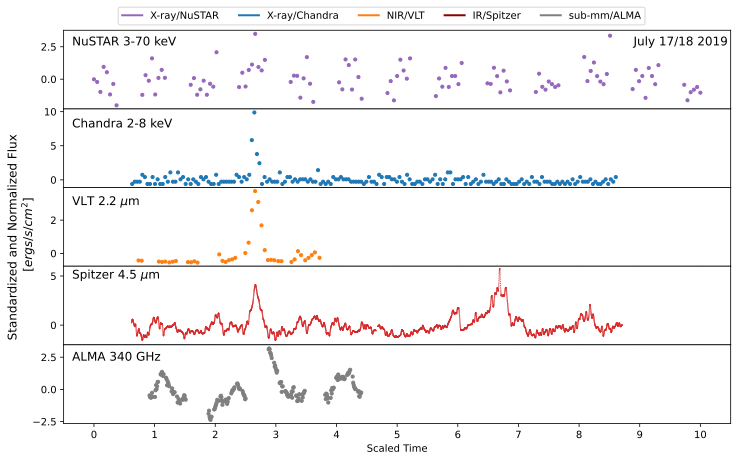

In [109]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]
nustar_flux = normalize(np.load('../../Data/nustar_flux.npy'))

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)

# Plot 1 - NuSTAR
# axs[0].errorbar(scaled_bmjd1, flux1, error1, fmt='o', color='tab:purple', markersize=3, linewidth=0.5)
axs[0].scatter(scaled_bmjd1, nustar_flux, s=10, color='tab:purple')
# axs[0].set_ylim(0, 0.5)
# axs[0].set_yticks([0.1, 0.2, 0.3, 0.4])
# axs[0].set_ylabel('[counts/s]')
# axs[0].set_ylabel(fr'[$ergs/s/cm^2$]')

# Plot 2 - Chandra
file2 = data_path + '0718chan.dat'
df2 = np.genfromtxt(file2, delimiter=' ')
bmjd2 = df2[:, 0]
scaled_bmjd2 = rescale_bmjd(bmjd2, bmjd1)
flux2 = df2[:, 1]
error2 = df2[:, 2]
chandra_flux = normalize(np.load('../../Data/chandra_flux.npy'))
# axs[1].errorbar(scaled_bmjd2, flux2, error2, linewidth=1, drawstyle='steps-mid', color='tab:blue')
axs[1].scatter(scaled_bmjd2, chandra_flux, s=10, color='tab:blue')
# axs[1].set_ylim(-0.05, 0.15)
# axs[1].set_yticks([0.0, 0.05, 0.10])
# axs[1].set_ylabel('[counts/s]')
# axs[1].set_ylabel(fr'[$ergs/s/cm^2$]')

# Plot 3 - VLT
file3 = data_path + '0718grav.dat'
df3 = np.genfromtxt(file3)
bmjd3 = df3[:, 0]
scaled_bmjd3 = rescale_bmjd(bmjd3, bmjd1)
flux3 = df3[:, 1]
error3 = df3[:, 2]
gravity_flux = normalize(np.load('../../Data/gravity_flux.npy'))
# axs[2].errorbar(scaled_bmjd3, flux3, error3, linewidth=2, drawstyle='steps-mid', color='tab:orange')
axs[2].scatter(scaled_bmjd3, gravity_flux, s=10, color='tab:orange')
# axs[2].set_ylim(-2, 21)
# axs[2].set_yticks([0, .5e-11, 1e-11, 1.5e-11])
# axs[2].set_ylabel('[mJy]')
# axs[2].set_ylabel(f'Normalized Flux \n [$ergs/s/cm^2$]')

# Plot 4 - Spitzer
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
scaled_bmjd4 = rescale_bmjd(bmjd4, bmjd1)
flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
spitzer_flux = normalize(np.load('../../Data/spitzer_flux.npy'))
# axs[3].plot(scaled_bmjd4, spitzer_flux, linewidth=1.2, color='darkred')
axs[3].scatter(scaled_bmjd4, spitzer_flux, s=0.1, color='tab:red')
# axs[3].scatter(scaled_bmjd4, flux_excess4, color='red', alpha=0.05, s=2)
axs[3].set_ylim(-2, 6)
# axs[3].set_yticks([-7, 0, 7, 14, 21])
# axs[3].set_ylabel('[mJy]')
# axs[3].set_ylabel(f'[$ergs/s/cm^2$]')

# Plot 5 - ALMA
file5 = data_path + '0718alma.dat'
df5 = np.genfromtxt(file5, delimiter=' ')
bmjd5 = df5[:, 2]
scaled_bmjd5 = rescale_bmjd(bmjd5, bmjd1)
flux5 = df5[:, 3]
alma_flux = normalize(np.load('../../Data/alma_flux.npy'))
axs[4].scatter(scaled_bmjd5, alma_flux, s=10, color='tab:gray')
# axs[4].set_ylim(3, 6)
# axs[4].set_yticks([3.0, 4.0, 5.0])
# axs[4].set_ylabel(fr'[$ergs/s/cm^2$]')

# Adjust subplot spacing
plt.tight_layout()

for ax in axs:
    ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.0f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs[4].set_xticks(xticks)
axs[4].set_xticklabels(xtick_labels)
axs[4].set_xlabel('Scaled Time')

legend_handles = [
    Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
    Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
    Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
    Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),
]

# Add annotations
fig.text(0.85, 0.94, 'July 17/18 2019', fontsize=12)
fig.text(0.070, 0.94, 'NuSTAR 3-70 keV', fontsize=12)
fig.text(0.070, 0.75, 'Chandra 2-8 keV', fontsize=12)
fig.text(0.070, 0.57, fr'VLT 2.2 $\mu$m', fontsize=12)
fig.text(0.070, 0.40, 'Spitzer 4.5 $\mu$m', fontsize=12)
fig.text(0.070, 0.21, 'ALMA 340 GHz', fontsize=12)

# Set y-label for all subplots
fig.text(-0.02, 0.5, 'Standardized and Normalized Flux \n                  [$ergs/s/cm^2$]', va='center', rotation='vertical', fontsize=12)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Show the combined figure
plt.savefig(save_path + 'results2.png', bbox_inches='tight')
plt.show()

In [110]:
# Randomly sample Spitzer data
fraction_to_keep = 0.05  # e.g., keep 10% of the data points
num_points_to_keep = int(fraction_to_keep * len(spitzer_flux))
indices = np.sort(np.random.choice(len(spitzer_flux), size=num_points_to_keep, replace=False))


time4 = scaled_bmjd4[indices]
flux4 = spitzer_flux[indices]
time4_test = np.delete(scaled_bmjd4, indices)
flux4_test = np.delete(spitzer_flux, indices)

# Create a single input array for all datasets
X1 = scaled_bmjd1[:, None]  # NuSTAR
X2 = scaled_bmjd2[:, None]  # Chandra
X3 = scaled_bmjd3[:, None]  # VLT
X4 = time4[:, None]  # Spitzer: replace by scaled_bmjd4 if you want all points or time4 if you want randomly undersampled spitzer points
X5 = scaled_bmjd5[:, None]  # ALMA

# Create a single output array for all datasets
# Y1 = normalize(flux1)
# Y2 = normalize(flux2)
# Y3 = normalize(flux3)
# Y4 = normalize(flux4)
# Y5 = normalize(flux5)

Y1 = nustar_flux
Y2 = chandra_flux
Y3 = gravity_flux
Y4 = flux4 # replace by spitzer_flux if you want all points or flux4 if you want randomly undersampled spitzer points
Y5 = alma_flux

# Y1 = flux1.reshape(-1, 1)
# Y2 = flux2.reshape(-1, 1)
# Y3 = flux3.reshape(-1, 1)
# Y4 = flux4.reshape(-1, 1)
# Y5 = flux5.reshape(-1, 1)

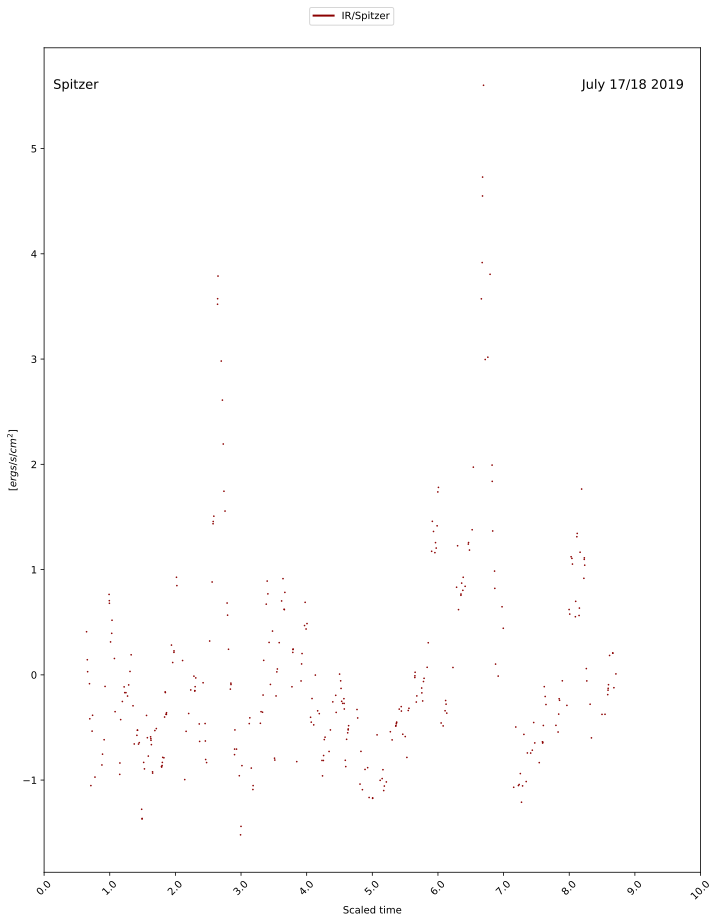

In [111]:
# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(time4, flux4, s=0.5, color='darkred')
# axs.set_ylim(-9, 23)
# axs.set_yticks([-7, 0, 7, 14, 21])
axs.set_ylabel(f'[$ergs/s/cm^2$]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
]

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'Spitzer', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

In [112]:
# Define kernels
K1 = GPy.kern.Bias(1)  # Bias kernel
K2 = GPy.kern.RBF(1)   # RBF kernel
K3 = GPy.kern.White(1)   # RBF kernel
K4 = GPy.kern.Matern32(1)

# Define lists
X_list = [X1, X2, X3, X4, X5]
Y_list = [Y1, Y2, Y3, Y4, Y5]
kernel_list = [K2]

# LCM kernel with three outputs
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=5, kernels_list=kernel_list)

# Create the GP coregionalized regression model
model = GPy.models.GPCoregionalizedRegression(X_list=X_list, Y_list=Y_list, kernel=lcm)

# Optimize the model
model.optimize()

# Display model parameters
display(model)
print(model.param_array)


[ 1.00977724e-01  8.04431279e-02  9.92990149e-01  1.94967155e+00
  1.93510559e+00  1.97318904e+00 -1.01070004e+00  5.37792781e-05
  2.95744167e+00  9.20676467e-08  4.37597513e+00  7.71315570e+00
  8.54460163e-01  3.58265561e-01  2.81271572e-03  6.49874589e-02
  2.56540831e-02]


In [146]:
def plot_mogp(model, X_list, Y_list, X_test=np.linspace(0, 10, 1000).reshape(-1, 1), colors=['tab:purple', 'tab:blue', 'tab:orange', 'tab:red', 'tab:gray'], quantiles=(16, 84), filename='results4.png', peak=None):
    
    num_outputs = len(X_list)
    fig = plt.figure(figsize=(10,6))
    gs = fig.add_gridspec(num_outputs, hspace=0)
    axs = gs.subplots(sharex=True)
    
    for i, X, Y, color in zip(range(num_outputs), X_list, Y_list, colors):
        
        X_index = np.hstack((X_test, (i * np.ones_like(X_test)).reshape(-1,1)))
        Y_metadata = {'output_index': X_index[:, 1:].astype(int)}

        preds = model.predict(X_index, Y_metadata=Y_metadata)
        lower, upper = model.predict_quantiles(X=X_index, Y_metadata=Y_metadata, quantiles=quantiles)
        lower, upper = lower.flatten(), upper.flatten()

        axs[i].plot(X_test, preds[0].flatten(), color='black')
        axs[i].fill_between(X_test.flatten(), lower, upper, alpha=0.25, color='grey')
        axs[i].scatter(X, Y, s=30, marker='o', color=color, alpha=0.8)
        if peak is not None and i == 3:
            axs[i].scatter(peak[0], peak[1], s=10, color='tab:green', alpha=0.5)
    

    # Adjust subplot spacing
    plt.tight_layout()

    for ax in axs:
        ax.label_outer()

    # Customize the x-axis tick labels
    xticks = np.linspace(0, 10, 11)
    xtick_labels = [f'{x:.0f}' for x in xticks]

    # Set the x-axis tick positions and labels for all subplots
    axs[4].set_xticks(xticks)
    axs[4].set_xticklabels(xtick_labels)
    axs[4].set_xlabel('Scaled Time')

    legend_handles = [
        Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
        Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
        Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
        Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
        Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),
    ]

    # Add annotations
    fig.text(0.85, 0.94, 'July 17/18 2019', fontsize=12)
    fig.text(0.070, 0.94, 'NuSTAR 3-70 keV', fontsize=12)
    fig.text(0.070, 0.75, 'Chandra 2-8 keV', fontsize=12)
    fig.text(0.070, 0.57, fr'VLT 2.2 $\mu$m', fontsize=12)
    fig.text(0.070, 0.40, 'Spitzer 4.5 $\mu$m', fontsize=12)
    fig.text(0.070, 0.21, 'ALMA 340 GHz', fontsize=12)

    # Set y-label for all subplots
    fig.text(-0.02, 0.5, 'Standardized and Normalized Flux \n                  [$ergs/s/cm^2$]', va='center', rotation='vertical', fontsize=12)


    # Add the legend with custom handles
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

    plt.savefig(save_path + filename, bbox_inches='tight')

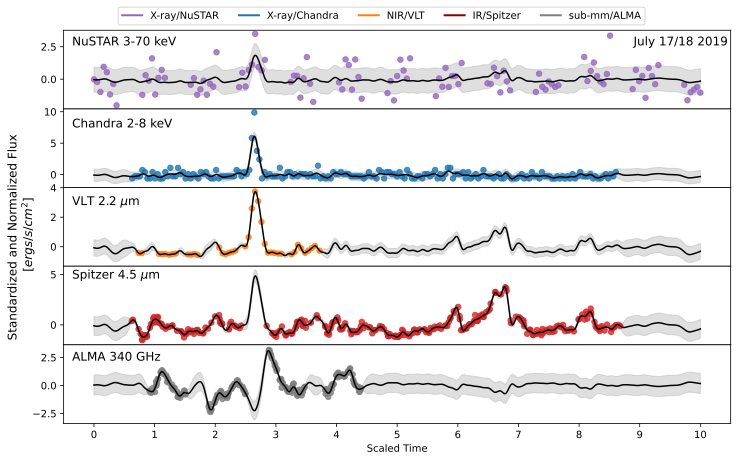

In [147]:
plot_mogp(model, X_list, Y_list)

## Comparison with SOGP

In [148]:
sogp = GPy.models.GPRegression(X_list[2], Y_list[2], K2)
sogp.optimize()
display(sogp)

sogp_preds = sogp.predict(X_list[2])[0]
myerr = abs(Y_list[2].flatten() - sogp_preds.flatten())

In [149]:
def plot_error(model, X_list, Y_list, colors=['tab:purple', 'tab:blue', 'tab:orange', 'tab:red', 'tab:gray'], quantiles=(16, 84)):
    
    num_outputs = len(X_list)
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(num_outputs, hspace=0)
    axs = gs.subplots(sharex=True)
    
    for i, X, Y, color in zip(range(num_outputs), X_list, Y_list, colors):

        sogp = GPy.models.GPRegression(X, Y, K2)
        sogp.optimize()

        sogp_preds = sogp.predict(X)[0]
        sogp_error = abs(Y.flatten() - sogp_preds.flatten())
        
        X_index = np.hstack((X, (i * np.ones_like(X)).reshape(-1, 1)))
        Y_metadata = {'output_index': X_index[:, 1:].astype(int)}

        preds = model.predict(X_index, Y_metadata=Y_metadata)
        error = abs(Y.flatten() - preds[0].flatten())
        
        axs[i].plot(X, error, color=color, alpha=0.5)
        # axs[i].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[i].plot(X, sogp_error, color='black', alpha=0.8, linestyle='--')

    # axs[2].plot(X_list[2], myerr, color='black', alpha=0.5)

    # Adjust subplot spacing
    plt.tight_layout()

    for ax in axs:
        ax.label_outer()

    # Customize the x-axis tick labels
    xticks = np.linspace(0, 10, 11)
    xtick_labels = [f'{x:.0f}' for x in xticks]

    # Set the x-axis tick positions and labels for all subplots
    axs[4].set_xticks(xticks)
    axs[4].set_xticklabels(xtick_labels)
    axs[4].set_xlabel('Scaled Time')

    legend_handles = [
        Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
        Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
        Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
        Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
        Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),
    ]

    # Add annotations
    fig.text(0.85, 0.94, 'July 17/18 2019', fontsize=12)
    fig.text(0.070, 0.94, 'NuSTAR 3-70 keV', fontsize=12)
    fig.text(0.070, 0.75, 'Chandra 2-8 keV', fontsize=12)
    fig.text(0.070, 0.57, fr'VLT 2.2 $\mu$m', fontsize=12)
    fig.text(0.070, 0.40, 'Spitzer 4.5 $\mu$m', fontsize=12)
    fig.text(0.070, 0.21, 'ALMA 340 GHz', fontsize=12)

    # Set y-label for all subplots
    fig.text(-0.03, 0.5, 'Absolute Error \n [$ergs/s/cm^2$]', va='center', rotation='vertical', fontsize=12)

    # Add the legend with custom handles
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

    plt.savefig(save_path + 'abs_error.png', bbox_inches='tight')
    plt.show()


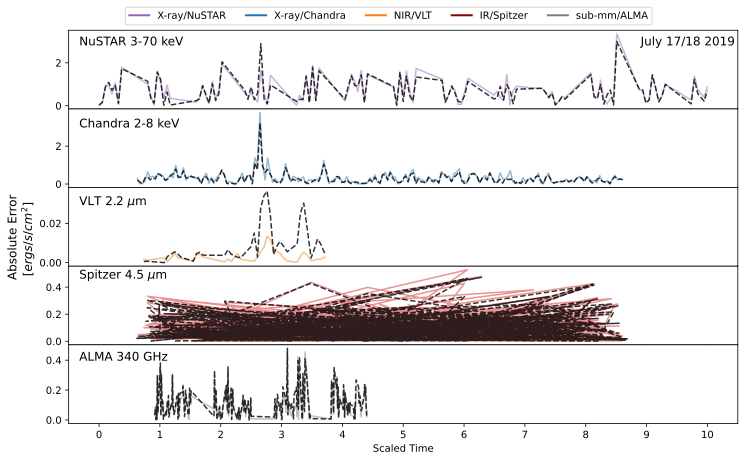

In [150]:
plot_error(model, X_list, Y_list)

## Removing a peak

In [151]:
peaks, _ = find_peaks(spitzer_flux.flatten(), height=0) 

# Calculate the prominence of each peak
prominences = peak_prominences(spitzer_flux.flatten(), peaks)[0]

# Find the index of the second most significant peak
sorted_indices = np.argsort(prominences)[::-1]
second_peak_idx = peaks[sorted_indices[1]]

# Determine the start and end of the second most significant peak
threshold = spitzer_flux[second_peak_idx] * 0  # Example threshold at 50% peak height

# Find where the signal rises above and falls below the threshold
start_idx = np.where(spitzer_flux[:second_peak_idx] < threshold)[0]
end_idx = np.where(spitzer_flux[second_peak_idx:] < threshold)[0]

start_idx = start_idx[-1] if len(start_idx) > 0 else 0
end_idx = second_peak_idx + end_idx[0] if len(end_idx) > 0 else len(spitzer_flux) - 1

# Print or use the start and end x-values
start_x = scaled_bmjd4[start_idx]
end_x = scaled_bmjd4[end_idx]

print(f"Second most significant peak starts at x = {start_x} and ends at x = {end_x}")


Second most significant peak starts at x = 2.510540279348098 and ends at x = 2.817453766512046


In [152]:
peak_indices = np.arange(start_idx, end_idx + 1)
peak_X_test = scaled_bmjd4[peak_indices]
peak_y_test = spitzer_flux[peak_indices]
temp_X_train = np.delete(scaled_bmjd4, peak_indices)
temp_y_train = np.delete(spitzer_flux, peak_indices)

In [153]:
fraction_to_keep = 0.05  # e.g., keep 10% of the data points
num_points_to_keep = int(fraction_to_keep * len(temp_X_train))
indices = np.random.choice(len(temp_X_train), size=num_points_to_keep, replace=False)

X_train = temp_X_train[indices]
y_train = temp_y_train[indices]
X_test = np.delete(temp_X_train, indices)
y_test = np.delete(temp_y_train, indices)

In [154]:
sort_indices = np.argsort(np.append(X_test, peak_X_test))
X_test = np.append(X_test, peak_X_test)[sort_indices]
y_test = np.append(y_test, peak_y_test)[sort_indices]

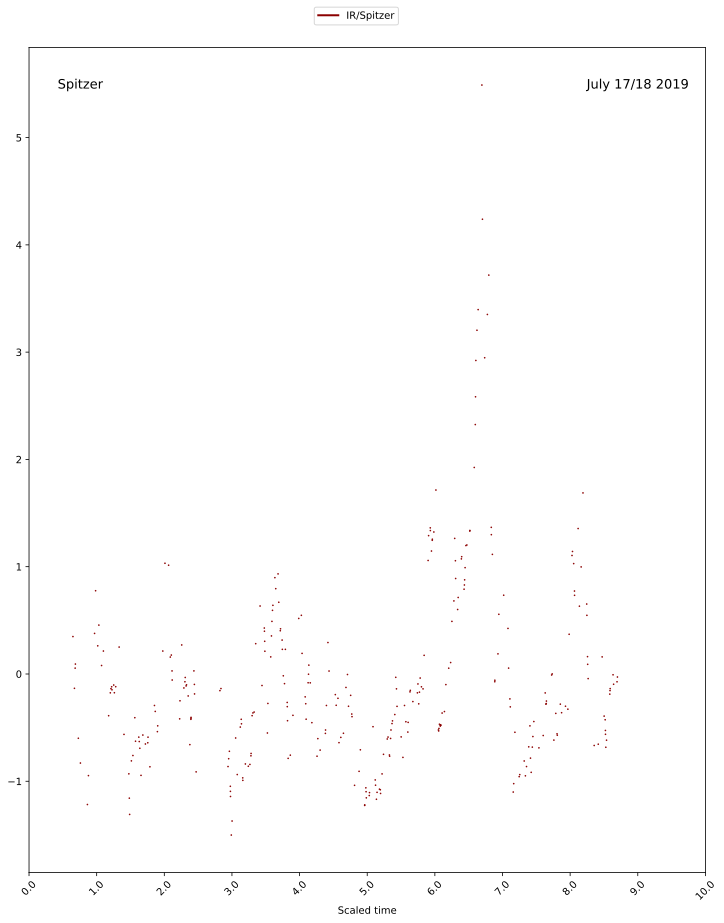

In [155]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(1, hspace=0)
axs = gs.subplots(sharex=True)

axs.scatter(X_train, y_train, s=0.5, color='darkred')
# axs.set_ylim(-9, 23)
# axs.set_yticks([-7, 0, 7, 14, 21])
# axs.set_ylabel('[mJy]')


# Adjust subplot spacing
plt.tight_layout()

ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.1f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=45)
axs.set_xlabel('Scaled time')

legend_handles = [
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
]

# Add annotations
fig.text(0.82, 0.94, 'July 17/18 2019', fontsize=13)
fig.text(0.085, 0.94, 'Spitzer', fontsize=13)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Add shaded area to all subplots
ax.axvspan(2.3, 2.9, color='#222e69', alpha=0.2)

# Show the combined figure
plt.show()

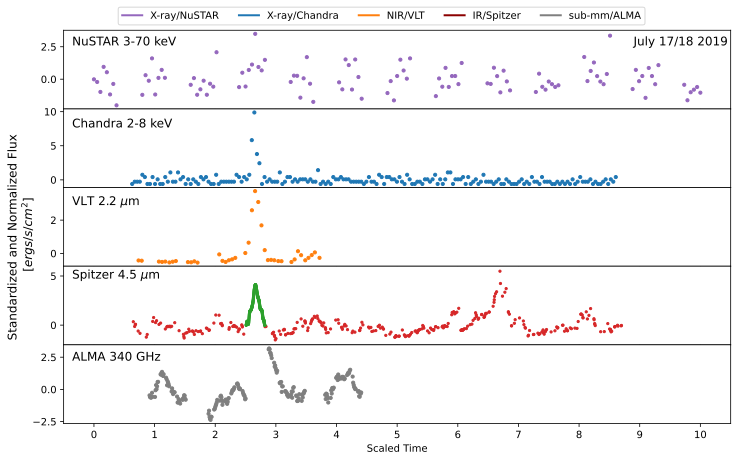

In [156]:
# Helper function to rescale bmjd values based on NuSTAR scaling
def rescale_bmjd(bmjd, reference_bmjd):
    return (bmjd - reference_bmjd[0]) / (reference_bmjd[-1] - reference_bmjd[0]) * 10

# Load NuSTAR data to get the reference bmjd scaling
file1 = data_path + '0718nust.dat'
df1 = np.genfromtxt(file1)
bmjd1 = df1[:, 0]
scaled_bmjd1 = rescale_bmjd(bmjd1, bmjd1)
flux1 = df1[:, 1]
error1 = df1[:, 2]
nustar_flux = normalize(np.load('../../Data/nustar_flux.npy'))

# Create a single figure with five subplots that share the same x-axis
fig = plt.figure(figsize=(10, 6))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True)

# Plot 1 - NuSTAR
# axs[0].errorbar(scaled_bmjd1, flux1, error1, fmt='o', color='tab:purple', markersize=3, linewidth=0.5)
axs[0].scatter(scaled_bmjd1, nustar_flux, s=10, color='tab:purple')
# axs[0].set_ylim(0, 0.5)
# axs[0].set_yticks([0.1, 0.2, 0.3, 0.4])
# axs[0].set_ylabel('[counts/s]')
# axs[0].set_ylabel(fr'[$ergs/s/cm^2$]')

# Plot 2 - Chandra
file2 = data_path + '0718chan.dat'
df2 = np.genfromtxt(file2, delimiter=' ')
bmjd2 = df2[:, 0]
scaled_bmjd2 = rescale_bmjd(bmjd2, bmjd1)
flux2 = df2[:, 1]
error2 = df2[:, 2]
chandra_flux = normalize(np.load('../../Data/chandra_flux.npy'))
# axs[1].errorbar(scaled_bmjd2, flux2, error2, linewidth=1, drawstyle='steps-mid', color='tab:blue')
axs[1].scatter(scaled_bmjd2, chandra_flux, s=10, color='tab:blue')
# axs[1].set_ylim(-0.05, 0.15)
# axs[1].set_yticks([0.0, 0.05, 0.10])
# axs[1].set_ylabel('[counts/s]')
# axs[1].set_ylabel(fr'[$ergs/s/cm^2$]')

# Plot 3 - VLT
file3 = data_path + '0718grav.dat'
df3 = np.genfromtxt(file3)
bmjd3 = df3[:, 0]
scaled_bmjd3 = rescale_bmjd(bmjd3, bmjd1)
flux3 = df3[:, 1]
error3 = df3[:, 2]
gravity_flux = normalize(np.load('../../Data/gravity_flux.npy'))
# axs[2].errorbar(scaled_bmjd3, flux3, error3, linewidth=2, drawstyle='steps-mid', color='tab:orange')
axs[2].scatter(scaled_bmjd3, gravity_flux, s=10, color='tab:orange')
# axs[2].set_ylim(-2, 21)
# axs[2].set_yticks([0, .5e-11, 1e-11, 1.5e-11])
# axs[2].set_ylabel('[mJy]')
# axs[2].set_ylabel(f'Normalized Flux \n [$ergs/s/cm^2$]')

# Plot 4 - Spitzer
file4 = data_path + '0718sptz.dat'
df4 = np.genfromtxt(file4)
bmjd4 = df4[:, 0]
scaled_bmjd4 = rescale_bmjd(bmjd4, bmjd1)
flux_excess4 = df4[:, 1] * 1e3
flux_binned4 = df4[:, 2] * 1e3
spitzer_flux = normalize(np.load('../../Data/spitzer_flux.npy'))
# axs[3].plot(scaled_bmjd4, spitzer_flux, linewidth=1.2, color='darkred')
axs[3].scatter(X_train.flatten(), y_train.flatten(), s=5, color='tab:red')
axs[3].scatter(peak_X_test.flatten(), peak_y_test.flatten(), s=5, color='tab:green')
# axs[3].scatter(scaled_bmjd4, flux_excess4, color='red', alpha=0.05, s=2)
axs[3].set_ylim(-2, 6)
# axs[3].set_yticks([-7, 0, 7, 14, 21])
# axs[3].set_ylabel('[mJy]')
# axs[3].set_ylabel(f'[$ergs/s/cm^2$]')

# Plot 5 - ALMA
file5 = data_path + '0718alma.dat'
df5 = np.genfromtxt(file5, delimiter=' ')
bmjd5 = df5[:, 2]
scaled_bmjd5 = rescale_bmjd(bmjd5, bmjd1)
flux5 = df5[:, 3]
alma_flux = normalize(np.load('../../Data/alma_flux.npy'))
axs[4].scatter(scaled_bmjd5, alma_flux, s=10, color='tab:gray')
# axs[4].set_ylim(3, 6)
# axs[4].set_yticks([3.0, 4.0, 5.0])
# axs[4].set_ylabel(fr'[$ergs/s/cm^2$]')

# Adjust subplot spacing
plt.tight_layout()

for ax in axs:
    ax.label_outer()

# Customize the x-axis tick labels
xticks = np.linspace(0, 10, 11)
xtick_labels = [f'{x:.0f}' for x in xticks]

# Set the x-axis tick positions and labels for all subplots
axs[4].set_xticks(xticks)
axs[4].set_xticklabels(xtick_labels)
axs[4].set_xlabel('Scaled Time')

legend_handles = [
    Line2D([0], [0], color='tab:purple', label='X-ray/NuSTAR', linewidth=2),
    Line2D([0], [0], color='tab:blue', label='X-ray/Chandra', linewidth=2),
    Line2D([0], [0], color='tab:orange', label='NIR/VLT', linewidth=2),
    Line2D([0], [0], color='darkred', label='IR/Spitzer', linewidth=2),
    Line2D([0], [0], color='tab:gray', label='sub-mm/ALMA', linewidth=2),
]

# Add annotations
fig.text(0.85, 0.94, 'July 17/18 2019', fontsize=12)
fig.text(0.070, 0.94, 'NuSTAR 3-70 keV', fontsize=12)
fig.text(0.070, 0.75, 'Chandra 2-8 keV', fontsize=12)
fig.text(0.070, 0.57, fr'VLT 2.2 $\mu$m', fontsize=12)
fig.text(0.070, 0.40, 'Spitzer 4.5 $\mu$m', fontsize=12)
fig.text(0.070, 0.21, 'ALMA 340 GHz', fontsize=12)

# Set y-label for all subplots
fig.text(-0.02, 0.5, 'Standardized and Normalized Flux \n                  [$ergs/s/cm^2$]', va='center', rotation='vertical', fontsize=12)

# Add the legend with custom handles
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.04), ncol=5)

# Show the combined figure
plt.savefig(save_path + 'results3.png', bbox_inches='tight')
plt.show()

### SOGP

In [157]:
model = GPy.models.GPRegression(X_train.reshape(-1, 1), y_train.reshape(-1, 1), kernel=GPy.kern.RBF(1))
model.optimize(messages=1)
model

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0002   3.606393e+02   3.483367e+03 
    00s19  0007   1.447629e+02   1.192326e+03 
    01s21  0027   1.175822e+02   3.643148e-08 
Runtime:     01s21
Optimization status: Converged



{'dataplot': [<matplotlib.collections.PathCollection at 0x75a1584a3fd0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x75a1584a07c0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x75a1584a09a0>]}

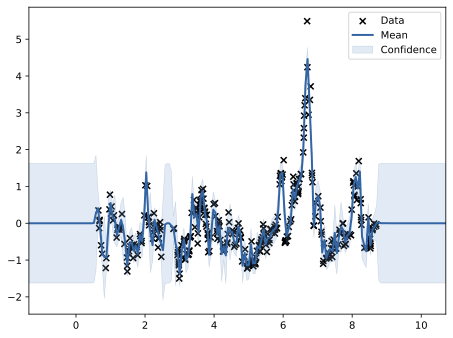

In [158]:
sogp_preds = model.predict(X4)[0]

model.plot()

### MOGP

In [166]:
# Define kernels
K1 = GPy.kern.Bias(1)  # Bias kernel
K2 = GPy.kern.RBF(1)   # RBF kernel
K3 = GPy.kern.White(1)   # RBF kernel
K4 = GPy.kern.Matern32(1)

# Define lists
X_list = [X1, X2, X3, X_train.reshape(-1, 1), X5]
Y_list = [Y1, Y2, Y3, y_train.reshape(-1, 1), Y5]
kernel_list = [K2]

# LCM kernel with three outputs
lcm = GPy.util.multioutput.LCM(input_dim=1, num_outputs=5, kernels_list=kernel_list)

# Create the GP coregionalized regression model
model = GPy.models.GPCoregionalizedRegression(X_list=X_list, Y_list=Y_list, kernel=lcm)

# Optimize the model
model.optimize()

# Display model parameters
display(model)
print(model.param_array)


[ 1.24345406e-01  7.69806530e-02 -9.03876111e-01 -1.74046674e+00
 -1.72138472e+00 -1.71339588e+00  6.70832875e-01  4.19414907e-05
  2.40341746e+00  7.18254488e-06  3.89101694e+00  6.09700872e+00
  8.50464500e-01  3.50008036e-01  9.74746884e-04  5.12924011e-02
  2.54257704e-02]


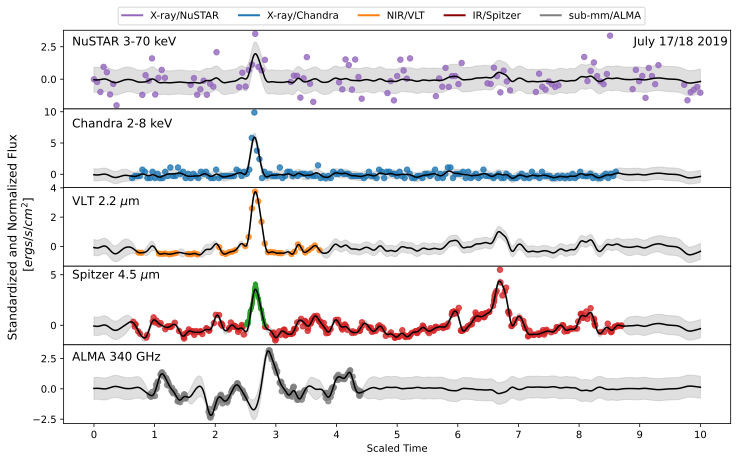

In [167]:
plot_mogp(model, X_list, Y_list, peak=[peak_X_test.flatten(), peak_y_test.flatten()])

### Verifying Kernel Plots

In [161]:
# import numpy as np

# # Number of outputs
# num_outputs = 5

# # Index of the wavelength to compare (fourth wavelength, index 3)
# compare_index = 3

# # Generate inputs
# X = np.linspace(0, 10, 100).reshape(-1, 1)
# X_full = np.vstack([np.hstack((X, i * np.ones_like(X))) for i in range(num_outputs)])

# # Compute the full kernel matrix
# K = model.kern.K(X_full)

# # Extract the relevant submatrix
# start_index = compare_index * 100
# end_index = start_index + 100
# K_sub = K[start_index:end_index, :]

# # The submatrix K_sub has shape (100, 500), we need to average over the 100 points
# K_mean = np.mean(K_sub, axis=0)

# # Reshape to get a (num_outputs, 100) matrix
# K_mean = K_mean.reshape(num_outputs, 100)


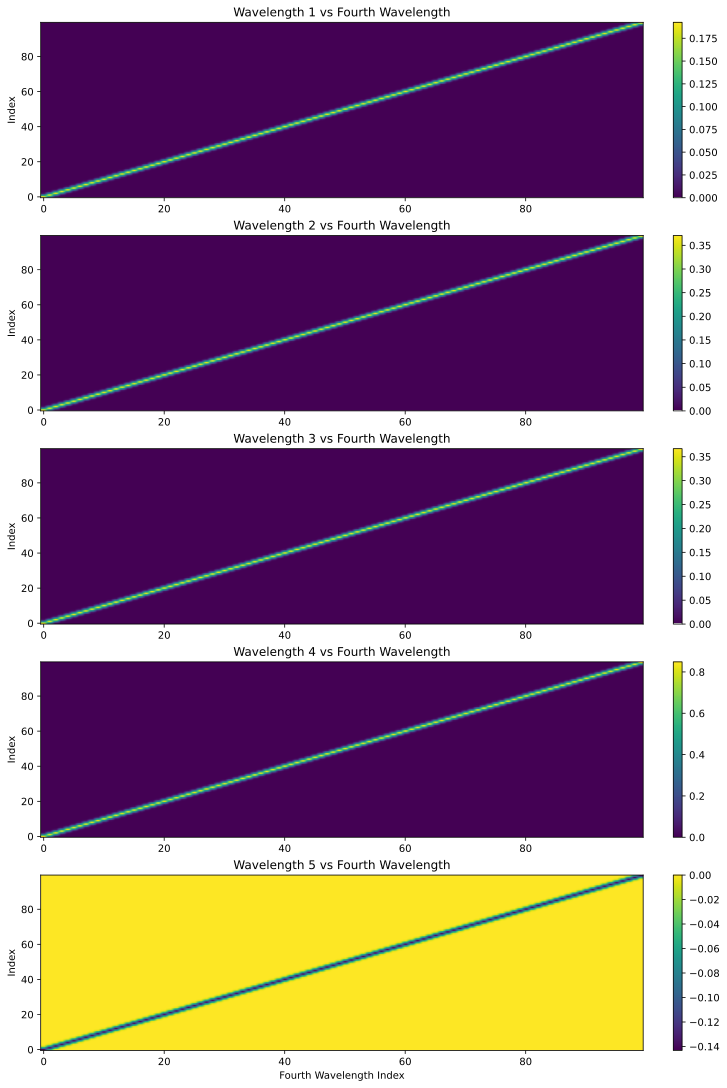

In [162]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming `model` is your multi-output GP model
# # Generate inputs
# X = np.linspace(0, 10, 100).reshape(-1, 1)
# num_outputs = 5
# compare_index = 3  # Index of the fourth wavelength

# # Generate full input for kernel calculation
# X_full = np.vstack([np.hstack((X, i * np.ones_like(X))) for i in range(num_outputs)])

# # Compute the full kernel matrix
# K = model.kern.K(X_full)

# # Extract submatrices for each output compared to the fourth
# K_submatrices = []
# for i in range(num_outputs):
#     start_index_i = i * 100
#     end_index_i = start_index_i + 100
#     start_index_compare = compare_index * 100
#     end_index_compare = start_index_compare + 100
    
#     K_sub = K[start_index_i:end_index_i, start_index_compare:end_index_compare]
#     K_submatrices.append(K_sub)

# # Plotting with imshow
# fig, axs = plt.subplots(5, 1, figsize=(10, 15), constrained_layout=True)

# for i, ax in enumerate(axs):
#     im = ax.imshow(K_submatrices[i], aspect='auto', origin='lower', cmap='viridis')
#     ax.set_title(f'Wavelength {i+1} vs Fourth Wavelength')
#     fig.colorbar(im, ax=ax)

# axs[-1].set_xlabel('Fourth Wavelength Index')
# for ax in axs:
#     ax.set_ylabel('Index')

# plt.show()


### Verifying residuals

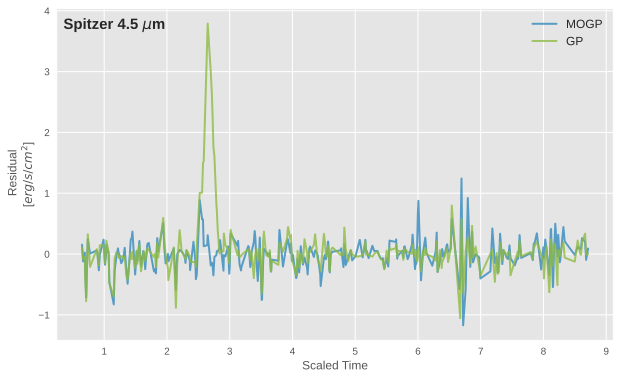

In [236]:
sogp_residuals = Y4.flatten() - sogp_preds.flatten()
sogp_error = np.sum(abs(sogp_residuals))


X_index = np.hstack((X4, (3 * np.ones_like(X4)).reshape(-1,1)))
Y_metadata = {'output_index': X_index[:, 1:].astype(int)}

mogp_preds = model.predict(X_index, Y_metadata=Y_metadata)[0]

mogp_residuals = Y4.flatten() - mogp_preds.flatten()
mogp_error = np.sum(abs(mogp_residuals))

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.plot(X4, mogp_residuals, alpha=0.8, color=color_cycle[1], linewidth=2, label='MOGP')
plt.plot(X4, sogp_residuals, alpha=0.8, color=color_cycle[5], linewidth=2, label='GP')
plt.ylabel(f' Residual\n[$erg/s/cm^2$]')
plt.xlabel('Scaled Time')
plt.legend(fontsize='large')
plt.text(0.35, 3.7, 'Spitzer 4.5 $\mu$m', fontsize=15, fontweight='bold')

plt.savefig(save_path + 'residuals.png')
plt.show()

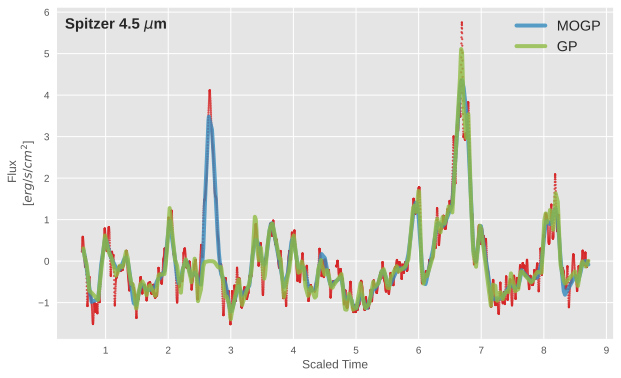

In [239]:
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.ylabel(f' Flux\n[$erg/s/cm^2$]')
plt.xlabel('Scaled Time')
plt.text(0.35, 5.6, 'Spitzer 4.5 $\mu$m', fontsize=15, fontweight='bold')

plt.scatter(scaled_bmjd4, spitzer_flux, alpha=0.8, color='tab:red', s=3)
plt.plot(X4, mogp_preds, linestyle='-', color=color_cycle[1], label='MOGP', linewidth=4, alpha=0.8)
plt.plot(X4, sogp_preds, linestyle='-', color=color_cycle[5], label='GP', linewidth=4, alpha=0.8)
plt.legend(fontsize='x-large')

plt.savefig(save_path + 'sogp_mogp_comparison_spitzer3.png')

plt.show()

# Kernel Plots

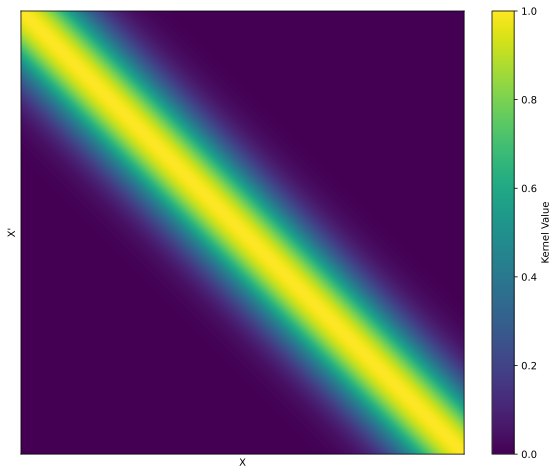

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import GPy

# Create input points
X = np.linspace(0, 10, 1000)[:, None]

# Define an RBF kernel
kernel = GPy.kern.RBF(1)

# Compute the kernel matrix
K = kernel.K(X)

# Plot the heatmap
plt.figure(figsize=(10, 8))
plt.imshow(K, interpolation='none', cmap='viridis')
plt.colorbar(label='Kernel Value')
plt.xlabel('X')
plt.ylabel('X\'')
plt.xticks([])  # Remove x ticks
plt.yticks([])  # Remove y ticks
# plt.show()

plt.savefig(save_path + 'kernel1.png')
